## Modeling family size distribution as an expression-dependent two-component mixture

### TODO

- The issue with large dynamic range of expression levels (maybe use different binning scale factors for different genes?)

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from commons import *
import scipy.sparse as sp
import logging
from collections import Counter

import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.util import broadcast_shape
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.contrib.autoguide import AutoDiagonalNormal
from torch.utils.data import TensorDataset, DataLoader

import torch
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all
from torch.distributions import constraints
from typing import Tuple
from numbers import Number

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

run_tests = True

## Load pre-generated fingerprint

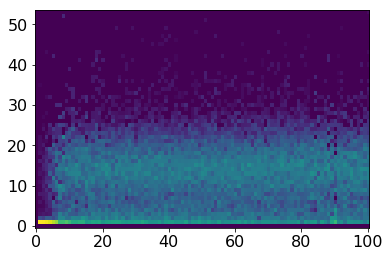

In [2]:
joint_fs_expr_fingerprint = np.load('/home/jupyter/data/10x/pbmc4k_fs_expr_fingerprint.npy')
mean_gene_expr = np.load('/home/jupyter/data/10x/pbmc4k_mean_gene_expr.npy')

# joint_fs_expr_fingerprint = np.load('/home/jupyter/data/PCL/LA_1600_1_fs_expr_fingerprint.npy')
# mean_gene_expr = np.load('/home/jupyter/data/PCL/LA_1600_1_mean_gene_expr.npy')

gene_index = 1897
fingerprint = joint_fs_expr_fingerprint[gene_index, :, :].copy()
fingerprint = fingerprint / (1e-8 + np.sum(fingerprint, axis=0)[None, :])

fig = plt.figure()
ax = plt.gca()
im = ax.imshow(np.log(1e-2 + fingerprint), origin='lower')
ax.set_aspect('auto')

## Probablistic model of joint fingerprints

torch.Size([])
torch.Size([])
Total probability: 0.9999998807907104


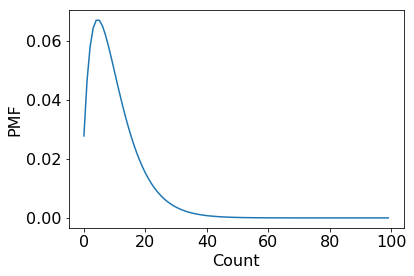

In [3]:
LN_1_M_EXP_THRESHOLD = -np.log(2.)


def get_log_prob_compl(log_prob):
    return torch.where(
        log_prob >= LN_1_M_EXP_THRESHOLD,
        torch.log(-torch.expm1(log_prob)),
        torch.log1p(-torch.exp(log_prob)))


class NegativeBinomial(TorchDistribution):
    r"""
    Creates a negative binomial distribution.
    
    Args:
        mu (Number, Tensor): mean (must be strictly positive)
        phi (Number, Tensor): overdispersion (must be strictly positive)
    """
    arg_constraints = {'mu': constraints.positive, 'phi': constraints.positive}
    support = constraints.positive_integer

    def __init__(self, mu, phi, validate_args=None):
        self.mu, self.phi = broadcast_all(mu, phi)
        if all(isinstance(_var, Number) for _var in (mu, phi)): 
            batch_shape = torch.Size()
        else:
            batch_shape = self.mu.size()
        super(NegativeBinomial, self).__init__(batch_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(NegativeBinomial, _instance)
        batch_shape = torch.Size(batch_shape)
        new.mu = self.mu.expand(batch_shape)
        new.phi = self.phi.expand(batch_shape)
        
        super(NegativeBinomial, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new
    
    @property
    def mean(self):
        return self.mu
    
    @property
    def variance(self):
        return self.mu + self.phi * self.mu.pow(2)
    
    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        mu, phi, value = broadcast_all(self.mu, self.phi, value)
        alpha = 1. / phi
        return ((value + alpha).lgamma() - (value + 1).lgamma() - alpha.lgamma()
                + alpha * (alpha.log() - (alpha + mu).log())
                + value * (mu.log() - (alpha + mu).log()))

# test
if run_tests:
    d = NegativeBinomial(10.0, 0.5)
    print(d.event_shape)
    print(d.batch_shape)
    value = torch.tensor(np.arange(0, 100, dtype=np.float)).float()
    p = np.exp(d.log_prob(value).numpy())
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(p[:100])
    ax.set_xlabel('Count', fontsize=16)
    ax.set_ylabel('PMF', fontsize=16)
    print(f'Total probability: {np.sum(p)}')

[TEST] Three component negative binomial mixture
Total probability: 1.0

[TEST] Shapes in mixture distribution
Component 1 (batch_shape: torch.Size([5, 2, 1]), event_shape: torch.Size([])
Component 2 (batch_shape: torch.Size([2, 1]), event_shape: torch.Size([])
Component 3 (batch_shape: torch.Size([]), event_shape: torch.Size([])
Weight 1 (shape: torch.Size([2, 1])
Weight 2 (shape: torch.Size([1])
Weight 3 (shape: torch.Size([1])

Component 1 in mixture distribution (batch_shape: torch.Size([5, 2, 1]), event_shape: torch.Size([])
Component 2 in mixture distribution (batch_shape: torch.Size([5, 2, 1]), event_shape: torch.Size([])
Component 3 in mixture distribution (batch_shape: torch.Size([5, 2, 1]), event_shape: torch.Size([])
Weight 1 in mixture distribution (shape: torch.Size([5, 2, 1])
Weight 2 in mixture distribution (shape: torch.Size([5, 2, 1])
Weight 3 in mixture distribution (shape: torch.Size([5, 2, 1])

value shape: torch.Size([10, 5, 2, 200])
log_prob shape: torch.Size([10,

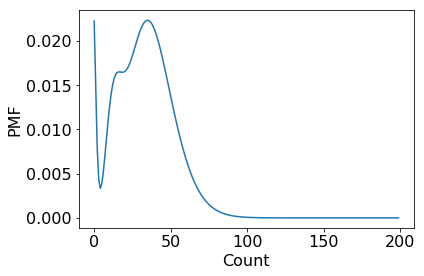

In [4]:
class MixtureConstraint(constraints.Constraint):
    def __init__(self, constraints: List[constraints.Constraint]):
        self.constraints = constraints

    def check(self, value):
        result = self.constraints[0].check(value)
        for constraint in self.constraints[1:]:
            result = result & constraint.check(value)
        return result


class MixtureDistribution(TorchDistribution):
    arg_constraints = {}  # nothing can be constrained

    def __init__(self, log_weights: Tuple[torch.Tensor], components: Tuple[TorchDistribution],
                 normalize_weights=False, validate_args=None):
        # basic sanity checks
        assert isinstance(log_weights, tuple)
        assert isinstance(components, tuple)
        assert len(log_weights) > 0
        assert len(log_weights) == len(components), \
            f'List of weights and components disagree: {len(log_weights)} vs {len(components)}'
        
        # all components must have the same event_shape
        event_shape = components[0].event_shape
        for component in components[1:]:
            assert component.event_shape == event_shape, \
                f'Components event_shape disagree: {component.event_shape} vs {event_shape}'
        
        # broadcast batch shapes across weights and components
        batch_shape = broadcast_shape(
            *(log_weight.shape for log_weight in log_weights),
            *(component.batch_shape for component in components))
        self.log_weights = tuple(log_weight.expand(batch_shape) if log_weight.shape != batch_shape else log_weight
                                 for log_weight in log_weights)
        self.components = tuple(component.expand(batch_shape) if component.batch_shape != batch_shape else component
                                for component in components)

        if normalize_weights:
            log_norm = torch.logsumexp(torch.cat(tuple(log_weight.unsqueeze(-1) for log_weight in self.log_weights), -1), -1)
            self.log_weights = tuple(log_weight - log_norm for log_weight in self.log_weights)

        super(MixtureDistribution, self).__init__(batch_shape, event_shape, validate_args)

    @constraints.dependent_property
    def support(self):
        first_component_support = self.components[0].support
        if all(component.support == first_component_support for component in self.components):
            return first_component_support
        return MixtureConstraint([component.support for component in self.components])

    def expand(self, batch_shape):
        log_weights = tuple(log_weight.expand(batch_shape) for log_weight in self.log_weights)
        components = tuple(component.expand(batch_shape) for component in self.components)
        return type(self)(log_weights, components)

    @property
    def mean(self):
        return torch.sum(
            torch.cat(
                tuple((log_weight.exp() * component.mean).unsqueeze(-1)
                      for log_weight, component in zip(self.log_weights, self.components)),
                -1),
            -1)
        
    def log_prob(self, value):
        value_shape = broadcast_shape(value.shape, self.batch_shape + self.event_shape)
        if value.shape != value_shape:
            value = value.expand(value_shape)
        if self._validate_args:
            self._validate_sample(value)
        weight_shape = value_shape[:len(value_shape) - len(self.event_shape)]
        log_weights = tuple(log_weight.expand(weight_shape) if log_weight.shape != weight_shape else log_weight
                            for log_weight in self.log_weights)
        log_probs = (component.log_prob(value) for component in self.components)
        return torch.logsumexp(torch.cat(tuple(log_prob.unsqueeze(-1) + log_weight.unsqueeze(-1)
                                          for log_prob, log_weight in zip(log_probs, log_weights)), -1), -1)


def test_three_component_neg_binom_mixture():
    print('[TEST] Three component negative binomial mixture')
    dist_1 = NegativeBinomial(1.0, 0.5)
    dist_2 = NegativeBinomial(15.0, 0.1)
    dist_3 = NegativeBinomial(40.0, 0.1)
    log_weight_1 = torch.tensor([0.1]).log()
    log_weight_2 = torch.tensor([0.4]).log()
    log_weight_3 = torch.tensor([1.5]).log()
    d = MixtureDistribution(
        (log_weight_1, log_weight_2, log_weight_3),
        (dist_1, dist_2, dist_3),
        normalize_weights=True)

    values = torch.arange(0, 200).float()
    p = d.log_prob(values).exp().numpy()
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(values.numpy(), p)
    ax.set_xlabel('Count', fontsize=16)
    ax.set_ylabel('PMF', fontsize=16)
    print(f'Total probability: {np.sum(p)}')
    print()

def test_mixture_distribution_batch_shape():
    print('[TEST] Shapes in mixture distribution')
    dist_1 = NegativeBinomial(1.0, 0.5).expand([5, 2, 1])
    dist_2 = NegativeBinomial(15.0, 0.1).expand([2, 1])
    dist_3 = NegativeBinomial(40.0, 0.1)
    log_weight_1 = torch.tensor([[0.1], [0.2]]).log()
    log_weight_2 = torch.tensor([0.4]).log()
    log_weight_3 = torch.tensor([1.5]).log()
    d = MixtureDistribution(
        (log_weight_1, log_weight_2, log_weight_3),
        (dist_1, dist_2, dist_3),
        normalize_weights=True)

    values = torch.arange(0, 200).float().expand([10, 5, 2, 200])
    log_prob = d.log_prob(values)
    total_prob = torch.sum(log_prob.exp(), -1)
    assert torch.allclose(total_prob, torch.ones_like(total_prob))
    
    print(f'Component 1 (batch_shape: {dist_1.batch_shape}, event_shape: {dist_1.event_shape}')
    print(f'Component 2 (batch_shape: {dist_2.batch_shape}, event_shape: {dist_2.event_shape}')
    print(f'Component 3 (batch_shape: {dist_3.batch_shape}, event_shape: {dist_3.event_shape}')
    print(f'Weight 1 (shape: {log_weight_1.shape}')
    print(f'Weight 2 (shape: {log_weight_2.shape}')
    print(f'Weight 3 (shape: {log_weight_3.shape}')
    print()

    print(f'Component 1 in mixture distribution (batch_shape: {d.components[0].batch_shape}, event_shape: {d.components[0].event_shape}')
    print(f'Component 2 in mixture distribution (batch_shape: {d.components[1].batch_shape}, event_shape: {d.components[1].event_shape}')
    print(f'Component 3 in mixture distribution (batch_shape: {d.components[2].batch_shape}, event_shape: {d.components[2].event_shape}')
    print(f'Weight 1 in mixture distribution (shape: {d.log_weights[0].shape}')
    print(f'Weight 2 in mixture distribution (shape: {d.log_weights[1].shape}')
    print(f'Weight 3 in mixture distribution (shape: {d.log_weights[2].shape}')
    print()
    
    print(f'value shape: {values.shape}')
    print(f'log_prob shape: {log_prob.shape}')
    print()

# tests
if run_tests:
    test_three_component_neg_binom_mixture()
    test_mixture_distribution_batch_shape()

Histogram log prob for compatible observation: -2277.551025390625
Histogram log prob for incompatible observation: -8790.728515625


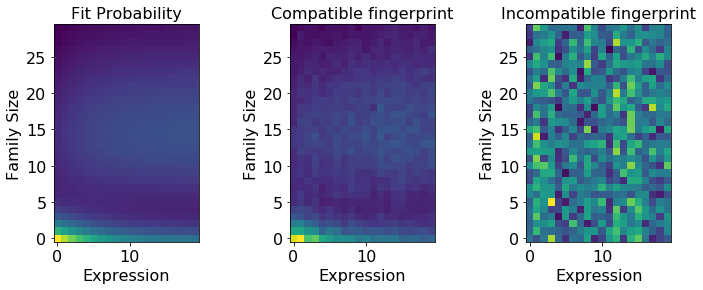

In [5]:
class BinnedHistogram(TorchDistribution):
    r"""TBW.
    """
    arg_constraints = {'fit_log_prob': constraints.less_than(0.)}
    support = constraints.nonnegative_integer
    EPS = 1e-8
    
    def __init__(self,
                 fit_log_prob,
                 normalize_fit_log_prob=True,
                 equalize_out_log_prob=False,
                 equalize_out_log_prob_level=0,
                 validate_args=None):
        assert isinstance(fit_log_prob, torch.Tensor)
        assert fit_log_prob.dim() >= 1
        self.fit_log_prob = fit_log_prob
        self.equalize_out_log_prob = equalize_out_log_prob
        self.equalize_out_log_prob_level = equalize_out_log_prob_level
        if normalize_fit_log_prob:
            self.fit_log_prob = self.fit_log_prob - torch.logsumexp(self.fit_log_prob, dim=-1, keepdim=True)
        batch_shape = self.fit_log_prob.size()
        super(BinnedHistogram, self).__init__(batch_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(BinnedHistogram, _instance)
        batch_shape = torch.Size(batch_shape)
        new.fit_log_prob = self.fit_log_prob.expand(batch_shape)
        new.equalize_out_log_prob = self.equalize_out_log_prob
        new.equalize_out_log_prob_level = self.equalize_out_log_prob_level
        
        super(BinnedHistogram, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new
        
    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        fit_log_prob, value = broadcast_all(self.fit_log_prob, value)
        n_obs = torch.sum(value, -1, keepdim=False)
        log_norm = (n_obs + 1).lgamma().unsqueeze(-1) / value.shape[-1]
        raw_log_prob = log_norm + value * self.fit_log_prob - (value + 1).lgamma()
        
        if self.equalize_out_log_prob:
            assert self.equalize_out_log_prob_level < value.dim()
            norm_fact = n_obs
            for _ in range(self.equalize_out_log_prob_level):
                norm_fact = torch.sum(norm_fact, 0)
            for _ in range(self.equalize_out_log_prob_level):
                norm_fact = norm_fact.unsqueeze(0)                
            return raw_log_prob / (self.EPS + norm_fact.expand_as(raw_log_prob))
        else:
            return raw_log_prob

# test
if run_tests:
    max_expr = 20
    max_fs = 30

    expr_vec = np.arange(1, max_expr + 1)
    fs_vec = np.arange(1, max_fs + 1)
    sigma_0 = 0.5
    sigma_1 = 0.2
    rate = 0.2
    w_lo = sigma_1 + (sigma_0 - sigma_1) * np.exp(-rate * (expr_vec - 1))
    w_lo = torch.tensor(w_lo).expand([max_fs, max_expr]).permute((1, 0)).float()

    mu_lo = 2.0 * torch.ones((max_expr, max_fs))
    phi_lo = 1.0 * torch.ones((max_expr, max_fs))
    mu_hi = 20.0 * torch.ones((max_expr, max_fs))
    phi_hi = 0.2 * torch.ones((max_expr, max_fs))

    dist_lo = NegativeBinomial(mu_lo, phi_lo)
    dist_hi = NegativeBinomial(mu_hi, phi_hi)
    log_w_lo = torch.log(w_lo)
    log_w_hi = get_log_prob_compl(log_w_lo)
    dist_mix = MixtureDistribution((log_w_lo, log_w_hi), (dist_lo, dist_hi))
    fs_tensor = torch.tensor(fs_vec).expand((max_expr, max_fs)).float()
    fit_log_prob = dist_mix.log_prob(fs_tensor)

    # generate test observation
    n_obs_per_expr = 5000 + (1000 * np.random.rand(max_expr)).astype(np.int)
    compatible_fingerprint = np.zeros_like(fs_tensor)
    incompatible_fingerprint = np.zeros_like(fs_tensor)
    for i_e in range(max_expr):
        probs = np.exp(fit_log_prob[i_e, :].numpy())
        probs = probs / np.sum(probs)
        compatible_fingerprint[i_e, :] = np.random.multinomial(
            n_obs_per_expr[i_e], probs)
        incompatible_fingerprint[i_e, :] = np.random.multinomial(
            n_obs_per_expr[i_e], np.ones_like(probs) / probs.size)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # fit probability
    ax = axs[0]
    im = ax.imshow(np.exp(fit_log_prob.numpy()).T, origin='lower')
    ax.set_xlabel('Expression', fontsize=16)
    ax.set_ylabel('Family Size', fontsize=16)
    ax.set_title('Fit Probability', fontsize=16)

    # compatible observation
    ax = axs[1]
    im = ax.imshow(compatible_fingerprint.T, origin='lower')
    ax.set_xlabel('Expression', fontsize=16)
    ax.set_ylabel('Family Size', fontsize=16)
    ax.set_title('Compatible fingerprint', fontsize=16)

    hist_p = BinnedHistogram(fit_log_prob).to_event(1)
    print(f'Histogram log prob for compatible observation: '
          f'{torch.sum(hist_p.log_prob(torch.tensor(compatible_fingerprint))).item()}')

    # incompatible observation
    ax = axs[2]
    im = ax.imshow(incompatible_fingerprint.T, origin='lower')
    ax.set_xlabel('Expression', fontsize=16)
    ax.set_ylabel('Family Size', fontsize=16)
    ax.set_title('Incompatible fingerprint', fontsize=16)

    hist_p = BinnedHistogram(fit_log_prob).to_event(1)
    print(f'Histogram log prob for incompatible observation: '
          f'{torch.sum(hist_p.log_prob(torch.tensor(incompatible_fingerprint))).item()}')

## Pyro model

In [6]:
device = torch.device('cuda')
dtype = torch.float

In [187]:
expression_binning_factor = 1
top_k_genes = 5000

# trim dataset to expressed genes
total_gene_expr_array = np.sum(np.sum(joint_fs_expr_fingerprint, -1), -1)
if top_k_genes is None:
    included_genes = np.where(total_gene_expr_array > 0)[0]
else:
    included_genes = np.asarray(
        list(map(operator.itemgetter(0),
                 sorted(enumerate(mean_gene_expr), key=operator.itemgetter(1), reverse=True))))[:top_k_genes]
    
working_gene_index_to_orig_gene_index_map = {i_1: i_2 for i_1, i_2 in enumerate(included_genes)}

# tensor dataset
gene_index_tensor = torch.arange(len(included_genes))
fingerprint_tensor = torch.tensor(joint_fs_expr_fingerprint[included_genes, 1:, 1:]).permute(0, 2, 1)
mean_gene_expr_tensor = torch.tensor(mean_gene_expr[included_genes], dtype=dtype)

if expression_binning_factor > 1:
    num_genes = fingerprint_tensor.shape[0]
    max_expression = fingerprint_tensor.shape[1]
    max_family_size = fingerprint_tensor.shape[2]

    max_binned_expression = max_expression // expression_binning_factor
    expression_binning_matrix = torch.zeros((max_expression, max_binned_expression), dtype=fingerprint_tensor.dtype)

    for i in range(max_binned_expression):
        i_begin = i * expression_binning_factor
        i_end = (i + 1) * expression_binning_factor
        expression_binning_matrix[i_begin:i_end, i] = 1
    fingerprint_tensor = torch.matmul(fingerprint_tensor.permute(0, 2, 1), expression_binning_matrix).permute(0, 2, 1)
    
fingerprint_dataset = TensorDataset(gene_index_tensor, mean_gene_expr_tensor, fingerprint_tensor)

# minibatcher
batch_size = 500
fingerprint_dataset_loader = DataLoader(
    fingerprint_dataset,
    batch_size=batch_size,
    shuffle=True)

In [188]:
from torch.distributions import transforms

class JointFamilySizeExpressionModel(torch.nn.Module):
    def __init__(self,
                 total_num_genes: int,
                 init_params_dict: dict,
                 equalize_likelihood: bool = False,
                 equalize_likelihood_level: int = 0,
                 init_xi_scale: float = 0.1,
                 device=torch.device('cuda'),
                 dtype=torch.float):
        super(JointFamilySizeExpressionModel, self).__init__()

        self.total_num_genes = total_num_genes
        self.init_params_dict = init_params_dict
        self.equalize_likelihood = equalize_likelihood
        self.equalize_likelihood_level = equalize_likelihood_level
        self.init_xi_scale = init_xi_scale
        self.device = device
        self.dtype = dtype
        self.n_nb_hi = len(init_params_dict['w_nb_hi'])
        self.n_nb_lo = len(init_params_dict['w_nb_lo'])
        self.stick = transforms.StickBreakingTransform()
        
    @property
    def total_global_dim(self):
        n_lo = 3 * self.n_nb_lo - 1
        n_hi = 3 * self.n_nb_hi - 1
        n_chim = 0
        return n_lo + n_hi + n_chim
    
    def xi_to_latent_dict(self, xi):
        assert xi.shape[-1] == self.total_global_dim
        offset = 0
        
        mu_lo = torch.exp(xi[..., offset:(offset + self.n_nb_lo)])
        offset += self.n_nb_lo
        
        phi_lo = torch.exp(xi[..., offset:(offset + self.n_nb_lo)])
        offset += self.n_nb_lo

        if self.n_nb_lo > 1:
            w_nb_lo = self.stick(xi[..., offset:(offset + self.n_nb_lo - 1)])
            offset += (self.n_nb_lo - 1)
        else:
            w_nb_lo = torch.ones_like(mu_lo)

        mu_hi = torch.exp(xi[..., offset:(offset + self.n_nb_hi)])
        offset += self.n_nb_hi
        
        phi_hi = torch.exp(xi[..., offset:(offset + self.n_nb_hi)])
        offset += self.n_nb_hi
        
        if self.n_nb_hi > 1:
            w_nb_hi = self.stick(xi[..., offset:(offset + self.n_nb_hi - 1)])
            offset += (self.n_nb_hi - 1)
        else:
            w_nb_hi = torch.ones_like(mu_hi)
        
#         omega_c = torch.exp(xi[..., offset:(offset + 1)])

        return {'mu_lo': mu_lo,
                'phi_lo': phi_lo,
                'w_nb_lo': w_nb_lo,
                'mu_hi': mu_hi,
                'phi_hi': phi_hi,
                'w_nb_hi': w_nb_hi}
                #'omega_c': omega_c}
    
    def latent_dict_to_xi(self, latent_dict):
        xi_tuple = tuple()
        xi_tuple += (torch.log(latent_dict['mu_lo']),)
        xi_tuple += (torch.log(latent_dict['phi_lo']),)
        if self.n_nb_lo > 1:
            xi_tuple += (self.stick.inv(latent_dict['w_nb_lo']),)
        xi_tuple += (torch.log(latent_dict['mu_hi']),)
        xi_tuple += (torch.log(latent_dict['phi_hi']),)
        if self.n_nb_hi > 1:
            xi_tuple += (self.stick.inv(latent_dict['w_nb_hi']),)
#         xi_tuple += (torch.log(latent_dict['omega_c']),)
        return torch.cat(xi_tuple, -1)

    def get_init_xi(self):
        mu_lo = torch.tensor(self.init_params_dict['mu_lo'], device=self.device, dtype=self.dtype)
        phi_lo = torch.tensor(self.init_params_dict['phi_lo'], device=self.device, dtype=self.dtype)
        w_nb_lo = torch.tensor(self.init_params_dict['w_nb_lo'], device=self.device, dtype=self.dtype)
        
        mu_hi = torch.tensor(self.init_params_dict['mu_hi'], device=self.device, dtype=self.dtype)
        phi_hi = torch.tensor(self.init_params_dict['phi_hi'], device=self.device, dtype=self.dtype)
        w_nb_hi = torch.tensor(self.init_params_dict['w_nb_hi'], device=self.device, dtype=self.dtype)

#         omega_c = torch.tensor(self.init_params_dict['omega_c'], device=self.device, dtype=self.dtype)
        
        return self.latent_dict_to_xi({
            'mu_lo': mu_lo,
            'phi_lo': phi_lo,
            'w_nb_lo': w_nb_lo,
            'mu_hi': mu_hi,
            'phi_hi': phi_hi,
            'w_nb_hi': w_nb_hi,
            #'omega_c': omega_c.unsqueeze(-1)
        })
        
    def model(self,
              gene_index_tensor: torch.Tensor,
              mean_gene_expr_tensor: torch.Tensor,
              fingerprint_tensor: torch.Tensor,
              xi_deterministic):
        # global prior of fingerprint model parameters
        xi_loc = pyro.param("xi_loc", self.get_init_xi())
        xi_scale_tril = pyro.param(
            "xi_scale_tril",
            self.init_xi_scale * torch.eye(self.total_global_dim, device=self.device, dtype=self.dtype),
            constraint=constraints.lower_cholesky)
        
        # chimera rate parameters
        omega_c = pyro.param("omega_c",
                             torch.tensor(self.init_params_dict['omega_c'], device=self.device, dtype=self.dtype),
                             constraint=constraints.positive)
        beta_c = pyro.param("beta_c",
                             torch.tensor(self.init_params_dict['beta_c'], device=self.device, dtype=self.dtype),
                             constraint=constraints.positive)
        
        gene_batch_size = fingerprint_tensor.shape[0]
        max_expression = fingerprint_tensor.shape[1]
        max_family_size = fingerprint_tensor.shape[2]
        expression_vector = torch.arange(1, max_expression + 1, device=self.device).type(self.dtype)
        family_size_vector = torch.arange(1, max_family_size + 1, device=self.device).type(self.dtype)

#         # w_lo brute-force posterior calculation grid
#         e_lo_max = 300
#         e_hi_max = 300
#         EPS = 1e-3
#         e_lo_grid = torch.arange(0, e_lo_max + 1).float().view((e_lo_max + 1, 1)).cuda()
#         e_hi_grid = torch.arange(0, e_hi_max + 1).float().view((1, e_hi_max + 1)).cuda()
#         log_w_lo_values = ((e_lo_grid + EPS) / (e_lo_grid + e_hi_grid + EPS)).log().view((1, 1, e_lo_max + 1, e_hi_max + 1))

        with pyro.poutine.scale(scale=self.total_num_genes / gene_batch_size):
            with pyro.plate("genes", size=gene_batch_size):
                # sample from the joint distribution of fingerprint model parameters in the unconstrained space
                if xi_deterministic is None:
                    xi = pyro.sample("xi", dist.MultivariateNormal(xi_loc, scale_tril=xi_scale_tril))
                else:
                    xi = xi_deterministic
                
                # transform to the constrained space
                latent_dict = self.xi_to_latent_dict(xi)

#                 with pyro.poutine.scale(scale=100.):
#                     pyro.sample("w_nb_hi_sparsity",
#                                 dist.Dirichlet(0.01 * torch.ones_like(latent_dict['w_nb_hi'])),
#                                 obs=latent_dict['w_nb_hi'])

                # instantiate the "chimeric" (lo) distribution
                log_w_nb_lo_tuple = tuple(latent_dict['w_nb_lo'][..., j].log().unsqueeze(-1) for j in range(self.n_nb_lo))
                nb_lo_components_tuple = tuple(NegativeBinomial(
                    latent_dict['mu_lo'][..., j].unsqueeze(-1),
                    latent_dict['phi_lo'][..., j].unsqueeze(-1)) for j in range(self.n_nb_lo))
                dist_lo = MixtureDistribution(log_w_nb_lo_tuple, nb_lo_components_tuple)
                
                # instantiate the "real" (hi) distribution
                log_w_nb_hi_tuple = tuple(latent_dict['w_nb_hi'][..., j].log().unsqueeze(-1) for j in range(self.n_nb_hi))
                nb_hi_components_tuple = tuple(NegativeBinomial(
                    latent_dict['mu_hi'][..., j].unsqueeze(-1),
                    latent_dict['phi_hi'][..., j].unsqueeze(-1)) for j in range(self.n_nb_hi))
                dist_hi = MixtureDistribution(log_w_nb_hi_tuple, nb_hi_components_tuple)

                # extract required quantities from the distributions
                mu_lo = dist_lo.mean
                mu_hi = dist_hi.mean
                p_obs_lo = torch.exp(get_log_prob_compl(
                    dist_lo.log_prob(torch.tensor(0, device=self.device, dtype=self.dtype))))
                p_obs_hi = torch.exp(get_log_prob_compl(
                    dist_hi.log_prob(torch.tensor(0, device=self.device, dtype=self.dtype))))

                # expected chimera formation rate per gene
                # omega_c = latent_dict['omega_c']
                with pyro.plate("expression", size=max_expression) as expression_indices:
                    plate_expression_vector = expression_vector[expression_indices]
                    expression_batch_size = len(expression_indices)
                    e_obs = plate_expression_vector.expand([gene_batch_size, expression_batch_size]).permute((1, 0)).unsqueeze(-1)
                    rate_e_lo = omega_c * mean_gene_expr_tensor.unsqueeze(-1) + (1 + beta_c * e_obs) * mu_hi / (p_obs_hi + omega_c * p_obs_lo * mu_hi)

#                     # calculate posterior expectation of w_lo                    
#                     e_obs_rate = (p_obs_lo.expand([expression_batch_size, gene_batch_size, 1]).unsqueeze(-1) * e_lo_grid +
#                                   p_obs_hi.expand([expression_batch_size, gene_batch_size, 1]).unsqueeze(-1) * e_hi_grid)
#                     log_joint = (dist.Poisson(rate_e_lo).log_prob(e_lo_grid.squeeze()).view((expression_batch_size, gene_batch_size, e_lo_max + 1, 1))
#                                  + dist.Poisson(e_obs_rate + EPS).log_prob(e_obs.unsqueeze(-1)))
#                     log_posterior = log_joint - torch.logsumexp(torch.logsumexp(log_joint, -1), -1).unsqueeze(-1).unsqueeze(-1)
#                     log_w_lo = torch.logsumexp(torch.logsumexp(log_w_lo_values + log_posterior, -1), -1).unsqueeze(-1)
#                     log_w_hi = get_log_prob_compl(log_w_lo)

                    e_lo = rate_e_lo.expand([expression_batch_size, gene_batch_size, 1])
                    e_hi = torch.clamp((e_obs - p_obs_lo * e_lo) / p_obs_hi, 1)                  
                    log_w_lo = torch.log(e_lo / (e_lo + e_hi))
                    log_w_hi = get_log_prob_compl(log_w_lo)

                    dist_mixture = MixtureDistribution((log_w_lo, log_w_hi), (dist_lo, dist_hi), normalize_weights=False)
                    
                    # generate histogram fit log prob
                    fit_log_prob = dist_mixture.log_prob(
                        family_size_vector.expand([expression_batch_size, gene_batch_size, max_family_size]))
                
                    # histogram log likelihood
                    binned_histrogram_dist = BinnedHistogram(
                        fit_log_prob,
                        normalize_fit_log_prob=True,
                        equalize_out_log_prob=self.equalize_likelihood,
                        equalize_out_log_prob_level=self.equalize_likelihood_level)

                    pyro.sample("observed_fingerprint_likelihood",
                                binned_histrogram_dist.to_event(1),
                                obs=fingerprint_tensor.permute(1, 0, 2))
                    
        return dist_lo, dist_hi, binned_histrogram_dist  
    
    def guide(self,
              gene_index_tensor: torch.Tensor,
              mean_gene_expr_tensor: torch.Tensor,
              fingerprint_tensor: torch.Tensor,
              xi_deterministic):
        xi_posterior_loc = pyro.param(
            "xi_posterior_loc", self.get_init_xi().expand([self.total_num_genes, self.total_global_dim]))
        xi_posterior_scale = pyro.param(
            "xi_posterior_scale",
            self.init_xi_scale * torch.ones((self.total_num_genes, self.total_global_dim), device=self.device, dtype=self.dtype),
            constraint=constraints.positive)
        
        gene_batch_size = fingerprint_tensor.shape[0]
        with pyro.plate("genes", size=gene_batch_size):
            xi = pyro.sample("xi", dist.Normal(
                loc=xi_posterior_loc[gene_index_tensor, :],
                scale=xi_posterior_scale[gene_index_tensor, :]).to_event(1))
#             xi = pyro.sample("xi", dist.Delta(v=xi_posterior_loc[gene_index_tensor, :]).to_event(1))
        
if run_tests:
    # test forward and backward mapping between xi and latent variables
    init_params_dict = {'mu_lo': [1.0],
                        'phu_lo': [10.0],
                        'w_nb_lo': [1.0],
                        'mu_hi': [1.0],
                        'phi_hi': [10.0],
                        'w_nb_hi': [1.0],
                        'omega_c': 0.1}
    model = JointFamilySizeExpressionModel(total_num_genes=10, init_params_dict=init_params_dict)
    
    # test xi to latent_dict mapping
    xi = torch.randn(3, 4, model.total_global_dim)
    latent_dict = model.xi_to_latent_dict(xi)
    err = np.allclose(model.latent_dict_to_xi(latent_dict).numpy(), xi.numpy())

In [189]:
pyro.clear_param_store()

init_params_dict = {
    'mu_lo': [0.1, 0.05],
    'phi_lo': [1.0, 1.0],
    'w_nb_lo': [0.5, 0.5],
    'mu_hi': [5.0, 7.0],
    'phi_hi': [0.2, 0.2],
    'w_nb_hi': [0.5, 0.5],
    'omega_c': 0.01,
    'beta_c': 0.01}

model = JointFamilySizeExpressionModel(
    total_num_genes=len(fingerprint_dataset),
    init_params_dict=init_params_dict,
    equalize_likelihood=False,
    equalize_likelihood_level=1,
    init_xi_scale=0.5)

In [190]:
def adam_args(module_name, param_name):
    if param_name == 'omega_c':
        return {"lr": 1e-2, "eps": 1e-3, "betas": (0.9, 0.9)}
    else:
        return {"lr": 1e-2, "eps": 1e-3, "betas": (0.9, 0.9)}
    
optim = pyro.optim.Adam(adam_args)
svi = SVI(model.model, model.guide, optim, loss=TraceEnum_ELBO())

In [191]:
mb_gene_index_tensor, mb_mean_gene_expr_tensor, mb_fingerprint_tensor = next(fingerprint_dataset_loader.__iter__())
trace = poutine.trace(model.model).get_trace(
    mb_gene_index_tensor.cuda(),
    mb_mean_gene_expr_tensor.cuda(),
    mb_fingerprint_tensor.float().cuda(),
    None)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

# d = model.model(mb_gene_index_tensor.cuda(),
#                         mb_mean_gene_expr_tensor.cuda(),
#                         mb_fingerprint_tensor.cuda().type(dtype))
# f = d.fit_log_prob.detach().cpu().numpy()
# plt.imshow(f[:, 7, :].T, origin='lower')

                       Trace Shapes:              
                        Param Sites:              
                              xi_loc         10   
                       xi_scale_tril      10 10   
                             omega_c              
                              beta_c              
                       Sample Sites:              
                          genes dist          |   
                               value     500  |   
                            log_prob          |   
                             xi dist     500  | 10
                               value     500  | 10
                            log_prob     500  |   
                     expression dist          |   
                               value     100  |   
                            log_prob          |   
observed_fingerprint_likelihood dist 100 500  | 53
                               value 100 500  | 53
                            log_prob 100 500  |   


In [192]:
loss_hist = []

In [201]:
n_epochs = 5000
print_loss_every = 10

for i_epoch in range(n_epochs):
    epoch_loss_list = []
    for mb_gene_index_tensor, mb_mean_gene_expr_tensor, mb_fingerprint_tensor in fingerprint_dataset_loader:
        loss = svi.step(mb_gene_index_tensor.cuda(),
                        mb_mean_gene_expr_tensor.cuda(),
                        mb_fingerprint_tensor.cuda().type(dtype),
                        None)
        epoch_loss_list.append(loss)
    
    epoch_loss_per_gene = np.mean(epoch_loss_list) / len(fingerprint_dataset)
    if i_epoch % print_loss_every == 0:
        print(f'Epoch number: {i_epoch}, Epoch loss: {epoch_loss_per_gene:.3f}')
        print(f'omega_c: {pyro.param("omega_c").item():.4f}')
        print(f'beta_c: {pyro.param("beta_c").item():.4f}')
    loss_hist.append(epoch_loss_per_gene)

Epoch number: 0, Epoch loss: 447.863
omega_c: 0.4411
beta_c: 0.1619
Epoch number: 10, Epoch loss: 447.169
omega_c: 0.4642
beta_c: 0.1662
Epoch number: 20, Epoch loss: 447.266
omega_c: 0.4917
beta_c: 0.1713
Epoch number: 30, Epoch loss: 447.179
omega_c: 0.5346
beta_c: 0.1767
Epoch number: 40, Epoch loss: 446.988
omega_c: 0.5772
beta_c: 0.1794
Epoch number: 50, Epoch loss: 446.923
omega_c: 0.5879
beta_c: 0.1875
Epoch number: 60, Epoch loss: 446.699
omega_c: 0.6359
beta_c: 0.1922
Epoch number: 70, Epoch loss: 446.565
omega_c: 0.6757
beta_c: 0.1977
Epoch number: 80, Epoch loss: 446.721
omega_c: 0.7065
beta_c: 0.2032
Epoch number: 90, Epoch loss: 446.598
omega_c: 0.7498
beta_c: 0.2104
Epoch number: 100, Epoch loss: 446.601
omega_c: 0.7804
beta_c: 0.2148
Epoch number: 110, Epoch loss: 446.374
omega_c: 0.8129
beta_c: 0.2193
Epoch number: 120, Epoch loss: 446.284
omega_c: 0.8602
beta_c: 0.2249
Epoch number: 130, Epoch loss: 446.328
omega_c: 0.9053
beta_c: 0.2295
Epoch number: 140, Epoch loss: 

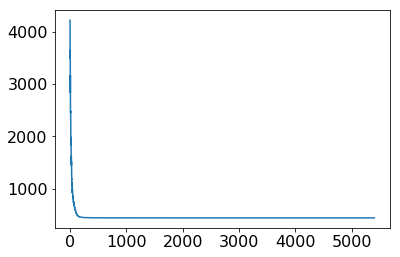

In [202]:
plt.plot(loss_hist)

In [203]:
model.xi_to_latent_dict(pyro.param("xi_loc"))

{'mu_lo': tensor([0.0361, 0.0047], device='cuda:0', grad_fn=<ExpBackward>),
 'phi_lo': tensor([19.8737,  4.0504], device='cuda:0', grad_fn=<ExpBackward>),
 'w_nb_lo': tensor([0.1849, 0.8151], device='cuda:0', grad_fn=<MulBackward0>),
 'mu_hi': tensor([ 7.5061, 16.8398], device='cuda:0', grad_fn=<ExpBackward>),
 'phi_hi': tensor([0.5723, 0.0301], device='cuda:0', grad_fn=<ExpBackward>),
 'w_nb_hi': tensor([0.5174, 0.4826], device='cuda:0', grad_fn=<MulBackward0>)}

tensor([0.0050, 0.0100, 0.0070, 0.0068, 0.0067, 0.0013, 0.0002, 0.0058, 0.0063,
        0.0031], device='cuda:0', grad_fn=<SliceBackward>)
{'mu_hi': tensor([[13.4626, 19.0209]], device='cuda:0', grad_fn=<ExpBackward>),
 'mu_lo': tensor([[0.0340, 0.0028]], device='cuda:0', grad_fn=<ExpBackward>),
 'phi_hi': tensor([[0.5347, 0.0228]], device='cuda:0', grad_fn=<ExpBackward>),
 'phi_lo': tensor([[23.0231,  4.1349]], device='cuda:0', grad_fn=<ExpBackward>),
 'w_nb_hi': tensor([[0.3811, 0.6189]], device='cuda:0', grad_fn=<MulBackward0>),
 'w_nb_lo': tensor([[0.1672, 0.8328]], device='cuda:0', grad_fn=<MulBackward0>)}
omega_c: 5.0762481689453125


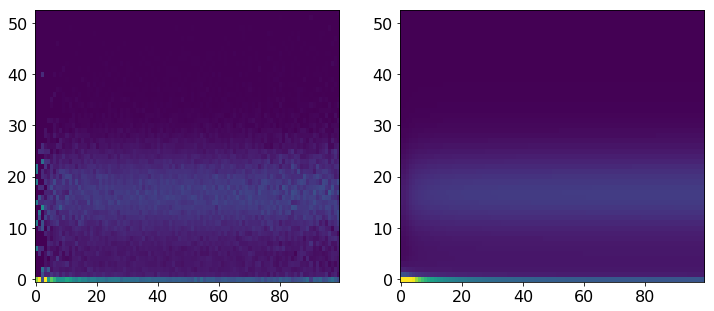

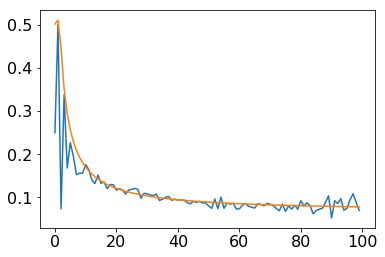

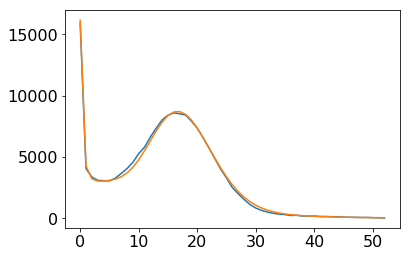

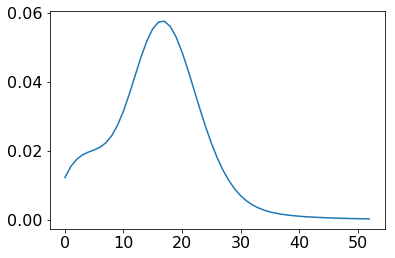

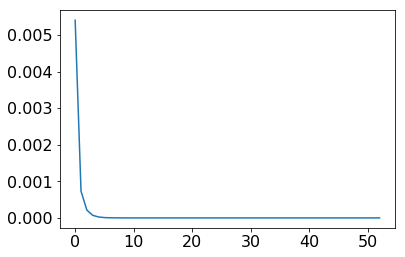

In [219]:
import pprint

gene_index = 9

xi_loc = pyro.param("xi_posterior_loc")[gene_index, :]
latent_dict = model.xi_to_latent_dict(xi_loc.unsqueeze(0))
omega_c = pyro.param('omega_c')

xi_scale = pyro.param("xi_posterior_scale")[gene_index, :]
print(xi_scale)
# omega_c = latent_dict['omega_c']

pprint.pprint({k: v for k, v in latent_dict.items()})
print(f'omega_c: {omega_c.item()}')

dist_lo, dist_hi, binned_histogram = model.model(
    fingerprint_dataset[gene_index][0].unsqueeze(0).cuda(),    
    fingerprint_dataset[gene_index][1].unsqueeze(0).cuda(),
    fingerprint_dataset[gene_index][2].unsqueeze(0).float().cuda(),
    xi_loc)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

empirical_fingerprint = fingerprint_dataset[gene_index][2].numpy()
total_expr = 1e-3 + np.sum(empirical_fingerprint, -1, keepdims=True)
empirical_fingerprint = empirical_fingerprint / total_expr

fit_log_prob = binned_histogram.fit_log_prob[:, 0, :]
reconstructed_fingerprint = np.exp(fit_log_prob[:, :].detach().cpu().numpy())

# total_obs_chim = (rate_e_lo * p_obs_lo).detach().cpu().numpy().item()
# chim_obs_rate = (total_obs_chim / mean_gene_expr_tensor[gene_index]).item()
# print(f'chimera rate in observed counts: {chim_obs_rate:.3f}')
# print(f'real molecule capture probability: {p_obs_hi.item():.3f}')

axs[0].imshow(empirical_fingerprint.T, origin='lower', aspect='auto', vmin=0, vmax=0.3)
axs[1].imshow(reconstructed_fingerprint.T, origin='lower', aspect='auto', vmin=0, vmax=0.3)

fig = plt.figure()
plt.plot(empirical_fingerprint[:, 0])
plt.plot(reconstructed_fingerprint[:, 0])

fig = plt.figure()
plt.plot(np.sum(empirical_fingerprint * total_expr, 0))
plt.plot(np.sum(reconstructed_fingerprint * total_expr, 0))

fig = plt.figure()
p_hi = dist_hi.log_prob(torch.arange(1, empirical_fingerprint.shape[1] + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_hi)

fig = plt.figure()
p_lo = dist_lo.log_prob(torch.arange(1, empirical_fingerprint.shape[1] + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_lo)

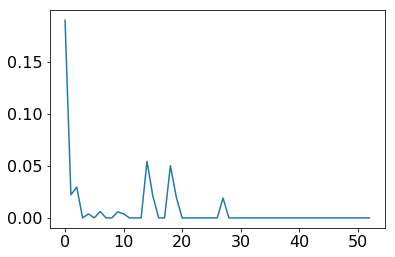

In [35]:
lo = torch.sum(fingerprint_tensor[3, 0:5, :], dim=0).float()
hi = torch.sum(fingerprint_tensor[3, 20:, :], dim=0).float()
lo = lo / torch.sum(lo)
hi = hi / torch.sum(hi)
diff = torch.clamp(lo - hi, 0)
plt.plot(diff.numpy())

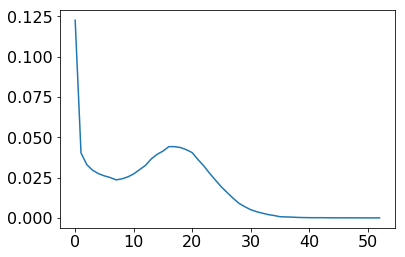

In [200]:
plt.plot(hi.numpy())

In [96]:
eta_lo = 0.3
eta_hi = 0.9
rate_lo = torch.tensor(10.0, requires_grad=True)
eps = 1e-10
e_lo_max = 200
e_hi_max = 200

e_obs_array = np.arange(1, 20)

# calculate log posterior
e_lo_grid = torch.arange(0, e_lo_max + 1).float().view((e_lo_max + 1, 1))
e_hi_grid = torch.arange(0, e_hi_max + 1).float().view((1, e_hi_max + 1))
e_obs_rate = eta_lo * e_lo_grid + eta_hi * e_hi_grid

w_lo_mean_list = []
w_lo_std_list = []
w_lo_approx_list = []

for e_obs in e_obs_array:
    log_joint = dist.Poisson(rate_lo).log_prob(e_lo_grid) + dist.Poisson(e_obs_rate + eps).log_prob(e_obs)
    log_posterior = log_joint - torch.logsumexp(torch.logsumexp(log_joint, -1), -1)

    # calculate posterior expectation of w_lo
    w_lo = (e_lo_grid + eps) / (e_lo_grid + e_hi_grid + eps)
    w_lo_mean = torch.logsumexp(torch.logsumexp(w_lo.log() + log_posterior, -1), -1).exp()
    
    w_lo_std = torch.sqrt(torch.sum((w_lo**2) * torch.exp(log_posterior)) - w_lo_mean**2)
    
    # approximate value
    e_lo_approx = rate_lo
    e_hi_approx = max((e_obs - eta_lo * e_lo_approx) / eta_hi, 1)
    w_lo_approx = e_lo_approx / (e_lo_approx + e_hi_approx)
    
    w_lo_mean_list.append(w_lo_mean.item())
    w_lo_std_list.append(w_lo_std.item())
    w_lo_approx_list.append(w_lo_approx)

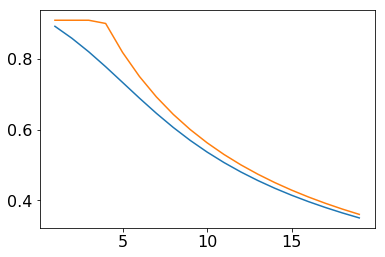

In [97]:
plt.plot(e_obs_array, w_lo_mean_list)
plt.plot(e_obs_array, w_lo_approx_list)